In [1]:
%pip install -q matplotlib networkx pandas torchinfo
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import functions
import json
import matplotlib.pyplot as plt
import poptorch
import torch

from dataset import LamaHDataset
from models import FloodMLP, FloodGCN, FloodGRAFFNN
from torchinfo import summary
from tqdm import tqdm

In [3]:
chkpt = torch.load("runs/2023-04-09_18-28-40.run")
HPARAMS = chkpt["hparams"]
print(json.dumps(HPARAMS, indent=4))

{
    "data": {
        "window_size": 24,
        "stride_length": 6,
        "lead_time": 1,
        "bidirectional": true,
        "normalized": true
    },
    "model": {
        "architecture": "GCN",
        "propagation_dist": 5,
        "hidden_size": 128,
        "residual": true,
        "adjacency_type": "binary",
        "shared_weights": true,
        "step_size": 1
    },
    "training": {
        "num_epochs": 20,
        "batch_size": 16,
        "learning_rate": 0.01,
        "weight_decay": 0
    }
}


In [4]:
dataset = LamaHDataset("LamaH-CE",
                       years=[2016, 2017],
                       window_size_hrs=HPARAMS["data"]["window_size"],
                       stride_length_hrs=1,  # get max out of data
                       lead_time_hrs=HPARAMS["data"]["lead_time"],
                       bidirectional=HPARAMS["data"]["bidirectional"],
                       normalized=HPARAMS["data"]["normalized"])

Loading dataset into memory...


100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


Layer (type:depth-idx)                   Param #
FloodGCN                                 --
├─Linear: 1-1                            3,200
├─Linear: 1-2                            129
├─ModuleList: 1-3                        --
│    └─GCNConv: 2-1                      16,512
│    └─GCNConv: 2-2                      16,512
│    └─GCNConv: 2-3                      16,512
│    └─GCNConv: 2-4                      16,512
│    └─GCNConv: 2-5                      16,512
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0


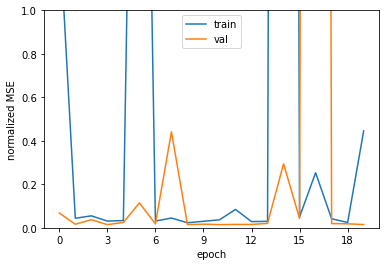

In [5]:
best_epoch = torch.tensor(chkpt["history"]["val_loss"]).argmin()
model_params = chkpt["history"]["model_params"][best_epoch]
edge_weights = functions.init_edge_weights(HPARAMS["model"]["adjacency_type"], dataset[0].edge_attr)
model = functions.construct_model(HPARAMS, edge_weights)
model.load_state_dict(model_params, strict=False)
print(summary(model, depth=2))
functions.plot_loss(chkpt["history"]["train_loss"], chkpt["history"]["val_loss"])

In [6]:
test_mse, test_nse = functions.evaluate(model, dataset, HPARAMS, on_ipu=True)
print(f"MSE: {test_mse.mean():.3f} | NSE: {test_nse.mean():.3f}")

# have to re-load model due to bug in poptorch
model = functions.construct_model(HPARAMS, edge_weights)
model.load_state_dict(model_params, strict=False)

Testing: 100%|██████████| 17496/17496 [00:09<00:00, 1807.75it/s]


MSE: 42.176 | NSE: 0.985


<All keys matched successfully>

In [7]:
data = dataset[0]

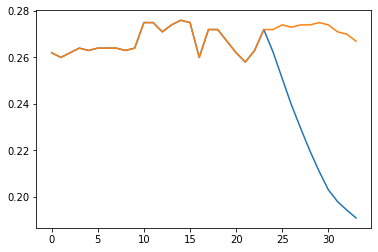

In [8]:
def autoforecast(model, data, num_steps):
    window = data.x
    with torch.no_grad():
        for i in range(num_steps):
            pred = model(window[:, i:], data.edge_index)
            window = torch.cat([window, pred], dim=1)
    return window

start = 0
duration = 10
data = dataset[start]

pred = autoforecast(model, data, duration)
truth = torch.cat([data.x] + [dataset[i].y for i in range(duration)], dim=1)

plt.plot(dataset.denormalize(pred)[0])
plt.plot(dataset.denormalize(truth)[0])

In [9]:
model(data.x, data.edge_index, evo_tracking=True).shape

len(model.evolution)

6

In [10]:
print(dataset.denormalize(truth)[0])

tensor([0.2620, 0.2600, 0.2620, 0.2640, 0.2630, 0.2640, 0.2640, 0.2640, 0.2630,
        0.2640, 0.2750, 0.2750, 0.2710, 0.2740, 0.2760, 0.2750, 0.2600, 0.2720,
        0.2720, 0.2670, 0.2620, 0.2580, 0.2630, 0.2720, 0.2720, 0.2740, 0.2730,
        0.2740, 0.2740, 0.2750, 0.2740, 0.2710, 0.2700, 0.2670])
